# Catch that asteroid!

In [28]:
from astropy import units as u
from astropy.time import Time

In [29]:
from astropy.utils.data import conf
conf.dataurl

'http://data.astropy.org/'

In [30]:
conf.remote_timeout 

10000.0

First, we need to increase the timeout time to allow the download of data occur properly

In [31]:
conf.remote_timeout = 10000

Then, we do the rest of the imports and create our initial orbits.

In [32]:
from astropy.coordinates import solar_system_ephemeris
solar_system_ephemeris.set("jpl")

from poliastro.bodies import *
from poliastro.twobody import Orbit
from poliastro.plotting import OrbitPlotter2D
from poliastro.plotting.misc import plot_solar_system

EPOCH = Time("2017-09-01 12:05:50", scale="tdb")

In [33]:
earth = Orbit.from_body_ephem(Earth, EPOCH)
earth

1 x 1 AU x 23.4 deg (ICRS) orbit around Sun (☉) at epoch 2017-09-01 12:05:50.000 (TDB)

In [34]:
earth.plot(label=Earth)

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(31, 119, 180)', 'dash':…

In [7]:
florence = Orbit.from_sbdb("Florence")
florence

1 x 3 AU x 22.1 deg (HeliocentricEclipticJ2000) orbit around Sun (☉) at epoch 2458600.5008007586 (TDB)

Two problems: the epoch is not the one we desire, and the inclination is with respect to the ecliptic!

In [8]:
florence.rv()

(<Quantity [-2.76132873e+08, -1.71570015e+08, -1.09377634e+08] km>,
 <Quantity [13.17478676, -9.82584123, -1.48126638] km / s>)

In [9]:
florence.epoch

<Time object: scale='tdb' format='jd' value=2458600.5008007586>

In [10]:
florence.epoch.iso

'2019-04-27 00:01:09.186'

In [11]:
florence.inc

<Quantity 22.14239434 deg>

We first propagate:

In [12]:
florence = florence.propagate(EPOCH)
florence.epoch.tdb.iso

'2017-09-01 12:05:50.000'

And now we have to convert to the same frame that the planetary ephemerides are using to make consistent comparisons, which is ICRS:

In [13]:
florence_icrs = florence.to_icrs()
florence_icrs.rv()

(<Quantity [ 1.46404253e+08, -5.35752830e+07, -2.05656912e+07] km>,
 <Quantity [ 7.3348819 , 23.48458627, 24.12473237] km / s>)

Let us compute the distance between Florence and the Earth:

In [14]:
from poliastro.util import norm

In [15]:
norm(florence_icrs.r - earth.r) - Earth.R

<Quantity 6967159.86628299 km>

<div class="alert alert-success">This value is consistent with what ESA says! $7\,060\,160$ km</div>

In [16]:
abs(((norm(florence_icrs.r - earth.r) - Earth.R) - 7060160 * u.km) / (7060160 * u.km))

<Quantity 0.01317252>

In [17]:
from IPython.display import HTML

HTML(
"""<blockquote class="twitter-tweet" data-lang="en"><p lang="es" dir="ltr">La <a href="https://twitter.com/esa_es">@esa_es</a> ha preparado un resumen del asteroide <a href="https://twitter.com/hashtag/Florence?src=hash">#Florence</a> 😍 <a href="https://t.co/Sk1lb7Kz0j">pic.twitter.com/Sk1lb7Kz0j</a></p>&mdash; AeroPython (@AeroPython) <a href="https://twitter.com/AeroPython/status/903197147914543105">August 31, 2017</a></blockquote>
<script src="//platform.twitter.com/widgets.js" charset="utf-8"></script>"""
)

And now we can plot!

In [18]:
frame = plot_solar_system(outer=False, epoch=EPOCH)
frame.plot(florence_icrs, label="Florence")

/home/lobo/Documentos/Github/poliastro/src/poliastro/twobody/propagation.py:232: UserWarning:

Frame <class 'astropy.coordinates.builtin_frames.icrs.ICRS'> does not support 'obstime', time values were not returned



FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(31, 119, 180)', 'dash':…

The difference between doing it well and doing it wrong is clearly visible:

In [19]:
frame = OrbitPlotter2D()

frame.plot(earth, label="Earth")

frame.plot(florence, label="Florence (Ecliptic)")
frame.plot(florence_icrs, label="Florence (ICRS)")

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(31, 119, 180)', 'dash':…

And now let's do something more complicated: express our orbit with respect to the Earth! For that, we will use GCRS, with care of setting the correct observation time:

In [20]:
from astropy.coordinates import GCRS, CartesianRepresentation

In [21]:
florence_heclip = florence.frame.realize_frame(
    florence.represent_as(CartesianRepresentation)
)

In [22]:
florence_gcrs_trans_cart = florence_heclip.transform_to(
    GCRS(obstime=EPOCH)
).represent_as(CartesianRepresentation)

florence_gcrs_trans_cart

<CartesianRepresentation (x, y, z) in km
    (5099276.0188933, -4713719.94283526, 639109.27180764)
 (has differentials w.r.t.: 's')>

In [23]:
florence_hyper = Orbit.from_vectors(
    Earth,
    r=florence_gcrs_trans_cart.xyz,
    v=florence_gcrs_trans_cart.differentials['s'].d_xyz,
    epoch=EPOCH
)
florence_hyper

6969897 x -6974244 km x 104.2 deg (GCRS) orbit around Earth (♁) at epoch 2017-09-01 12:05 (TDB)

We now retrieve the ephemerides of the Moon, which are given directly in GCRS:

In [24]:
moon = Orbit.from_body_ephem(Moon, EPOCH)
moon

367937 x 405209 km x 19.4 deg (GCRS) orbit around Earth (♁) at epoch 2017-09-01 12:05 (TDB)

In [25]:
moon.plot(label=Moon)

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(31, 119, 180)', 'dash':…

And now for the final plot:

In [26]:
import matplotlib.pyplot as plt
plt.ion()

from poliastro.plotting.static import StaticOrbitPlotter

/home/lobo/Documentos/Github/poliastro/src/poliastro/twobody/orbit.py:842: OrbitSamplingWarning:

anomaly outside range, clipping



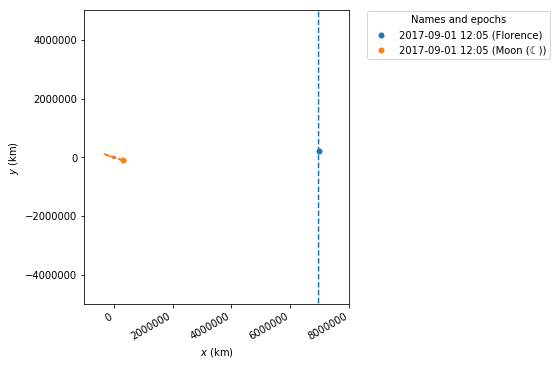

In [27]:
frame = StaticOrbitPlotter()

# This first plot sets the frame
frame.plot(florence_hyper, label="Florence")

# And then we add the Moon
frame.plot(moon, label=Moon)

plt.xlim(-1000000, 8000000)
plt.ylim(-5000000, 5000000)

plt.gcf().autofmt_xdate()

<div style="text-align: center; font-size: 3em;"><em>Per Python ad astra!</em></div>